In [1]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

main_path = Path("")

In [7]:
def do_stats(platform, skip_leaning=False, output_path='GENERAL-DATA-STATISTICS'):
    col = "user_id" if platform != "telegram" else "channel_id"
    file_prefix = "user_id" if platform != "telegram" else "channel"
    # 1. Number of unique users
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{file_prefix}2urls.parquet", columns=[col])
    print(f"{len(df[col].unique()):,} unique {col} in {platform}")
    
    # 2. Number of users with leaning
    if not skip_leaning:
        df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{file_prefix}2urls_with_leaning.parquet", columns=["leaning"])
        print(df.select(pl.col("leaning").value_counts())["leaning"])
    
    # 3. Number of unique urls
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{file_prefix}2urls.parquet", columns=["urls"])
    unique_urls_count = (
        df.explode("urls")  # Turn each list of URLs into individual rows
        .select(pl.col("urls").unique())  # Get unique URLs
        .height  # Get the number of unique URLs
    )
    print(f"{unique_urls_count:,} unique urls in {platform}")
    
    
    # 4. Number of unique domains
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{file_prefix}2urls_expanded_domains.parquet", columns=["domains_expanded"])
    unique_domains_count = (
        df.explode("domains_expanded")  # Turn each list of URLs into individual rows
        .select(pl.col("domains_expanded").unique())  # Get unique URLs
        .height  # Get the number of unique URLs
    )
    print(f"{unique_domains_count:,} unique domains in {platform}")

    
    # 5. Number of unique messages
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{platform}_cleaned.parquet", columns=["message_id", 'message'])
    print(f"{len(df['message_id'].unique()):,} unique id messages in {platform}")
    print(f"{len(df['message'].unique()):,} unique text messages in {platform}")

    # 5.1 Number of unique messages filtered for analysis
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{file_prefix}2message_cleaned.parquet", columns=["message_id", 'message'])
    print(f"{len(df['message_id'].unique()):,} unique filtered message ids for AI analysis in {platform}")
    print(f"{len(df['message'].unique()):,} unique filtered text messages for AI analysis in {platform}")
    
    # 6. Average number of messages per user
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{platform}_cleaned.parquet", columns=[col, "message_id"])
    df = df.group_by(col).agg(
        pl.col("message_id").count().alias("message_count")
    )
    mean_messages = df["message_count"].mean()
    median_messages = df["message_count"].median()
    std_messages = df["message_count"].std()
    print(f"Average number of messages per {col}: {mean_messages:.1f}")
    print(f"Median number of messages per {col}: {median_messages:.1f}")
    print(f"Standard deviation of messages per {col}: {std_messages:.1f}")
    plt.hist(df["message_count"], bins=50, edgecolor='black', alpha=0.7)
    #plt.title(f'Distribution of Number of Messages per {col.capitalize().replace("_id", "")}')
    plt.xlabel('Number of Messages')
    plt.ylabel(f'Number of {col.capitalize().replace("_id", "")}')
    plt.yscale("log")
    plt.grid(True)
    sns.despine()
    os.makedirs(f'{output_path}/', exist_ok=True)
    if output_path:
        plt.tight_layout()
        plt.savefig(f'{output_path}/{platform}-distribution-messages.pdf', dpi=300, bbox_inches='tight') 
    plt.show()
    
    # 7. Number of characters
    df = pl.read_parquet(main_path / Path(platform + "-clean") / f"{platform}_cleaned.parquet", columns=["message"])
    df = df.with_columns(
        pl.col("message").str.len_chars().alias("message_length")
    )
    mean_length = df["message_length"].mean()
    median_length = df["message_length"].median()
    std_length = df["message_length"].std()
    print(f"Average message length: {mean_length:.1} characters")
    print(f"Median message length: {median_length:.1} characters")
    print(f"Standard deviation of message length: {std_length:.1} characters")
    plt.hist(df["message_length"], bins=50, edgecolor='black', alpha=0.7)
    #plt.title('Distribution of Message Lengths')
    plt.xlabel('Message Length (characters)')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.axvline(x=125, color="red")
    plt.axvline(x=1_000, color="red")
    plt.grid(True)
    sns.despine()
    os.makedirs(f'{output_path}/', exist_ok=True)
    if output_path:
        plt.tight_layout()
        plt.savefig(f'{output_path}/{platform}-distribution-characters.pdf', dpi=300, bbox_inches='tight') 
    plt.show()

178,379 unique user_id in twitter
shape: (3,)
Series: 'leaning' [struct[2]]
[
	{"",161550}
	{"left",9513}
	{"right",7316}
]
582,052 unique urls in twitter
35,922 unique domains in twitter
6,021,428 unique id messages in twitter
5,229,567 unique text messages in twitter
2,381,605 unique filtered message ids for AI analysis in twitter
2,318,688 unique filtered text messages for AI analysis in twitter
Average number of messages per user_id: 4.7
Median number of messages per user_id: 1.0
Standard deviation of messages per user_id: 20.3


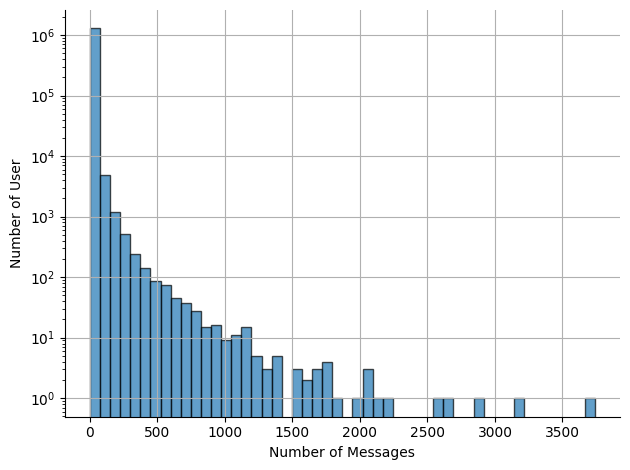

Average message length: 1e+02 characters
Median message length: 9e+01 characters
Standard deviation of message length: 9e+01 characters


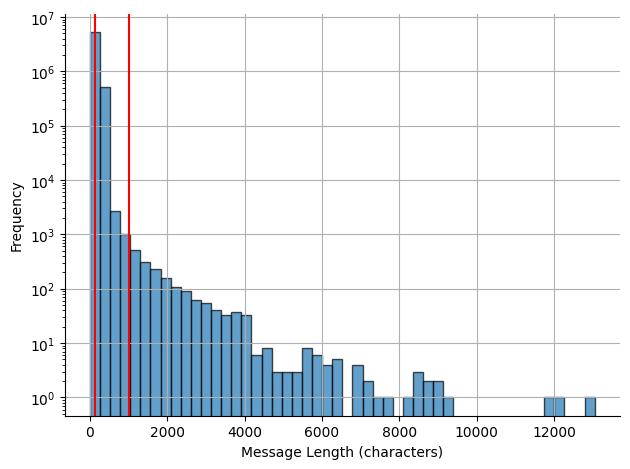

In [8]:
do_stats("twitter")

6,137 unique user_id in facebook
shape: (3,)
Series: 'leaning' [struct[2]]
[
	{"left",143}
	{"right",109}
	{"",5885}
]
15,009 unique urls in facebook
5,247 unique domains in facebook
46,310 unique id messages in facebook
134,623 unique text messages in facebook
27,723 unique filtered message ids for AI analysis in facebook
74,043 unique filtered text messages for AI analysis in facebook
Average number of messages per user_id: 3.7
Median number of messages per user_id: 1.0
Standard deviation of messages per user_id: 14.7


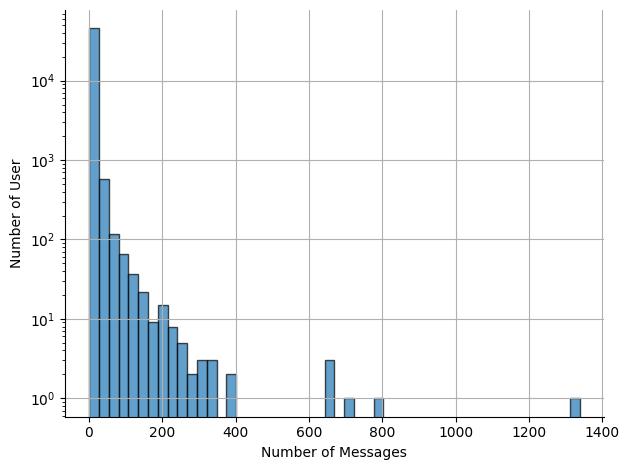

Average message length: 6e+02 characters
Median message length: 2e+02 characters
Standard deviation of message length: 1e+03 characters


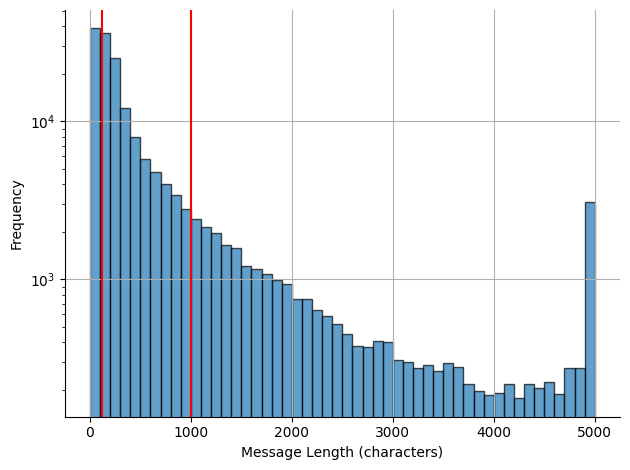

In [9]:
do_stats("facebook")

15,537 unique channel_id in telegram
shape: (3,)
Series: 'leaning' [struct[2]]
[
	{"",13121}
	{"left",753}
	{"right",1663}
]
2,087,078 unique urls in telegram
183,924 unique domains in telegram
4,309,880 unique id messages in telegram
21,252,650 unique text messages in telegram
3,083,066 unique filtered message ids for AI analysis in telegram
9,988,344 unique filtered text messages for AI analysis in telegram
Average number of messages per channel_id: 2674.6
Median number of messages per channel_id: 133.0
Standard deviation of messages per channel_id: 16993.4


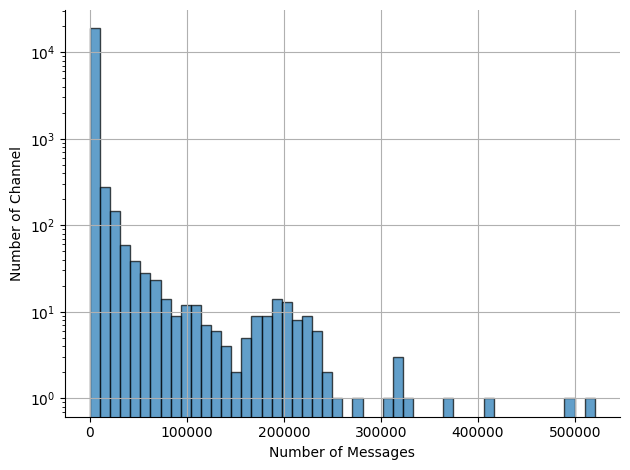

Average message length: 4e+02 characters
Median message length: 3e+02 characters
Standard deviation of message length: 4e+02 characters


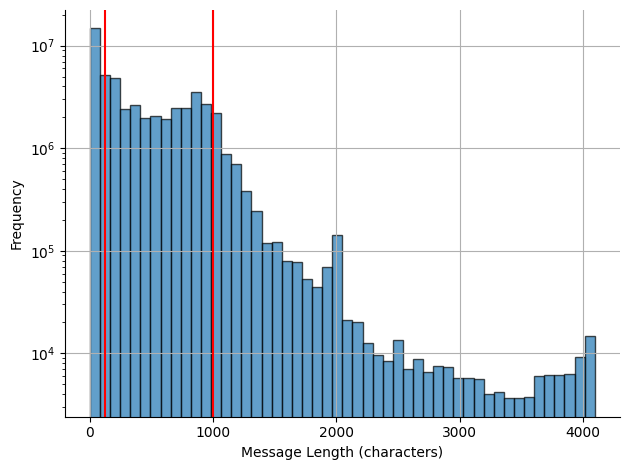

In [11]:
do_stats("telegram")